# Data Preprocessing

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

We start by importing all the relevant datasets, including the main dataset that was provided by our advisor. It contains data on Stack Overflow activity by NUTS3 region over the years.

In [3]:
# Load the main dataset
dataFileName = os.path.join("Data", "stackoecdmatch_Nova.dta")
SO_activity = pd.read_stata(dataFileName)
SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP_Y15_64_,EMP_Y15_MAX_,GVA_CURR_PR_,GVA_REAL_PPP_,GVA_REAL_PR_,GVA_USD_PPP_,POP_T
0,2009.0,,,0.0,0.0,53.0,4.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010.0,,,3.0,4.0,287.0,10.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011.0,,,2.0,11.0,964.0,18.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012.0,,,0.0,6.0,920.0,33.0,405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013.0,,,0.0,0.0,1825.0,103.0,556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Basic Data Cleaning

In [8]:
# Convert 'year' columnn from float to integer
SO_activity['year'] = SO_activity['year'].astype(int)
SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP_Y15_64_,EMP_Y15_MAX_,GVA_CURR_PR_,GVA_REAL_PPP_,GVA_REAL_PR_,GVA_USD_PPP_,POP_T
0,2009,,,0.0,0.0,53.0,4.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,,,3.0,4.0,287.0,10.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011,,,2.0,11.0,964.0,18.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012,,,0.0,6.0,920.0,33.0,405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013,,,0.0,0.0,1825.0,103.0,556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Replace empty strings with NaN in the 'country' column
SO_activity['country'].replace('', np.nan, inplace=True)

# Drop rows where the 'country' column is empty (NaN)
SO_activity.dropna(subset=['country'], inplace=True)

SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP_Y15_64_,EMP_Y15_MAX_,GVA_CURR_PR_,GVA_REAL_PPP_,GVA_REAL_PR_,GVA_USD_PPP_,POP_T
13,2000,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,296000.0,NaN,NaN,NaN,NaN,NaN
14,2001,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,543685.0
15,2002,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,550298.0
16,2003,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,555782.0
17,2004,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,560674.0


When checking for NaN values we can see that there are a lot of missing values for the socio-economic factors. For employment we have more than 50% of the values missing:

In [11]:
SO_activity.shape

(8426, 15)

In [6]:
SO_activity.isnull().sum()

year                0
nuts3_name          0
country             0
questioncount       0
answercount         0
upvotecount         0
downvotecount       0
commentcount        0
EMP_Y15_64_      5064
EMP_Y15_MAX_     3861
GVA_CURR_PR_     2318
GVA_REAL_PPP_    2318
GVA_REAL_PR_     2318
GVA_USD_PPP_     2318
POP_T             519
dtype: int64

We drop the existing economic factors due to the many missing values. Also, we were not sure where the data came from and how those factors were defined (probably OECD data). Therefore, we decided to define the indicators that we want to use ourselves and find meaningful data from Eurostats that represents those indicators. 

In the end, the goal is to handle any kind of missing values in order to ensure that our future models perform well.

In [12]:
# Drop the columns with the economic factors
SO_activity = SO_activity.iloc[:, :8]

SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount
13,2000,Aargau,CH,0.0,0.0,0.0,0.0,0.0
14,2001,Aargau,CH,0.0,0.0,0.0,0.0,0.0
15,2002,Aargau,CH,0.0,0.0,0.0,0.0,0.0
16,2003,Aargau,CH,0.0,0.0,0.0,0.0,0.0
17,2004,Aargau,CH,0.0,0.0,0.0,0.0,0.0


## Merging Economic Factors

In order to join the main dataset with the Eurostats data, we need an identifier that ensures that the values are merged correctly. For this, we can use the NUTS3 names that we have in the main dataset. 

However, the Eurostats data uses NUTS3 codes to identify the different regions. Therefore, we first had to match our NUTS3 regions with the corresponding codes. We used the official Excel sheet provided by Eurostats that maps the regions to their codes.

We realized that some of the region names in the main dataset differ from the names in the Eurostats dataset. We identified those differences and compiled a mapping file called **Nuts3 Correction** that helps us link both files without losing data:

| **StackOverflow Activity Name** | **Eurostats Name** |
|--------------------------------|-------------------|
| Bern                           | Bern / Berne      |
| Fribourg (CH)                  | Fribourg / Freiburg |
| Graubünden                     | Graubünden / Grigioni / Grischun |
| Jura (CH)                      | Jura              |
| Lucerne                        | Luzern            |
| Valais                         | Valais / Wallis   |
| Alicante                       | Alicante/Alacant  |
| Balearic Islands               | Mallorca (assumed main island for Balearic Islands) |
| Biscay                         | Bizkaia           |
| Castellón                      | Castellón/Castelló |
| Córdoba (ES)                   | Córdoba           |
| Gerona                         | Girona            |
| La Corunna                     | A Coruña          |
| Lérida                         | Lleida            |
| Navarre                        | Navarra           |
| Orense                         | Ourense           |
| Saragossa                      | Zaragoza          |
| Seville                        | Sevilla           |
| Valencia                       | Valencia/València |
| Aosta Valley                   | Valle d’Aosta/Vallée d’Aoste |
| Florence                       | Firenze           |
| Genoa                          | Genova            |
| L'Aquila                       | L’Aquila          |
| Mantua                         | Mantova           |
| Milan                          | Milano            |
| Naples                         | Napoli            |
| Padua                          | Padova            |
| Reggio nell'Emilia             | Reggio nell’Emilia |
| Rome                           | Roma              |
| Turin                          | Torino            |
| Venice                         | Venezia           |
| Blekinge County                | Blekinge län      |
| Dalarna County                 | Dalarnas län      |
| Gotland County                 | Gotlands län      |
| Gävleborg County               | Gävleborgs län    |
| Halland County                 | Hallands län      |
| Jämtland County                | Jämtlands län     |
| Jönköping County               | Jönköpings län    |
| Kalmar County                  | Kalmar län        |
| Kronoberg County               | Kronobergs län    |
| Norrbottens County             | Norrbottens län   |
| Skåne County                   | Skåne län         |
| Stockholm County               | Stockholms län    |
| Södermanland County            | Södermanlands län |
| Uppsala County                 | Uppsala län       |
| Värmlands County               | Värmlands län     |
| Västerbottens County           | Västerbottens län |
| Västernorrland County          | Västernorrlands län |
| Västmanland County             | Västmanlands län  |
| Västra Götaland County         | Västra Götalands län |
| Örebro County                  | Örebro län        |
| Östergötland County            | Östergötlands län |
| Adiyaman                       | Adıyaman          |
| Afyon                          | Afyonkarahisar    |
| Agri                           | Ağrı              |
| Aydin                          | Aydın             |
| Balikesir                      | Balıkesir         |
| Bartin                         | Bartın            |
| Diyarbakir                     | Diyarbakır        |
| Elazig                         | Elazığ            |
| Eskisehir                      | Eskişehir         |
| Gümüshane                      | Gümüşhane         |
| Igdir                          | Iğdır             |
| Istanbul                       | İstanbul          |
| Izmir                          | İzmir             |
| Kahramanmaras                  | Kahramanmaraş     |
| Kirikkale                      | Kırıkkale         |
| Kirklareli                     | Kırklareli        |
| Kirsehir                       | Kırşehir          |
| Mugla                          | Muğla             |
| Mus                            | Muş               |
| Nevsehir                       | Nevşehir          |
| Nigde                          | Niğde             |
| Sanliurfa                      | Şanlıurfa         |
| Sirnak                         | Şırnak            |
| Tekirdag                       | Tekirdağ          |
| Usak                           | Uşak              |
| Çankiri                        | Çankırı           |


In [13]:
# Load the excel file that maps the nuts3_name from the SO data with the nuts3_codes in Eurostats data
dataFileName2 = os.path.join("Data", "Nuts3 Correction.xlsx")

# Read the Excel file
nuts3_codes_df = pd.read_excel(dataFileName2)

# Display the first few rows
nuts3_codes_df.head()

,Country Code,Country,nuts3_name,NUTS level 3,Code 2021
0,TR,Turkey,Adiyaman,Adıyaman,TRC12
1,TR,Turkey,Afyon,Afyonkarahisar,TR332
2,TR,Turkey,Agri,Ağrı,TRA21
3,IT,Italy,Aosta Valley,Valle d’Aosta/Vallée d’Aoste,ITC20
4,TR,Turkey,Aydin,Aydın,TR321


In [14]:
# Merge both files to visualize each region and its corresponding nuts3_code including the SO data
SO_activity= pd.merge(SO_activity, nuts3_codes_df[['nuts3_name', 'Code 2021']], on='nuts3_name', how='left')
SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,Code 2021
0,2000,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033
1,2001,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033
2,2002,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033
3,2003,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033
4,2004,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033


In [15]:
# Verify that there are no missing values
SO_activity.isna().sum()

year             0
nuts3_name       0
country          0
questioncount    0
answercount      0
upvotecount      0
downvotecount    0
commentcount     0
Code 2021        0
dtype: int64

As mentioned before, there was insuficient data in the given dataset. We opted to search for the indicators.

Source: [EUROSTATS](https://inserlinkhere)

In [16]:
# Merge of all the Eurostats data

# Define the columns to read from each file
emp_cols = ['geo', 'TIME_PERIOD', 'EMP']
gdp_cols = ['geo', 'TIME_PERIOD', 'GDP', 'unit']
gva_cols = ['geo', 'TIME_PERIOD', 'GVA', 'unit']
pop_cols = ['geo', 'TIME_PERIOD', 'POP']

# Read the files with only necessary columns
emp_df = pd.read_csv("Data/eurostats_emp.csv", usecols=emp_cols)
gdp_df = pd.read_csv("Data/eurostats_gdp.csv", usecols=gdp_cols)
gva_df = pd.read_csv("Data/eurostats_gva.csv", usecols=gva_cols)
pop_df = pd.read_csv("Data/eurostats_pop.csv", usecols=pop_cols)

# Rename columns to include unit names
emp_df.rename(columns={'EMP': 'EMP (THS)'}, inplace=True)
pop_df.rename(columns={'POP': 'POP (THS)'}, inplace=True)

# Pivot the GDP dataframe to reshape it
gdp_pivoted = gdp_df.pivot(index=['geo', 'TIME_PERIOD'], columns='unit', values='GDP').reset_index()
gdp_pivoted.columns = ['geo', 'TIME_PERIOD'] + [f'GDP ({unit})' for unit in gdp_pivoted.columns[2:]]

# Pivot the GVA dataframe to reshape it
gva_pivoted = gva_df.pivot(index=['geo', 'TIME_PERIOD'], columns='unit', values='GVA').reset_index()
gva_pivoted.columns = ['geo', 'TIME_PERIOD'] + [f'GVA ({unit})' for unit in gva_pivoted.columns[2:]]

# Merge all dataframes on 'geo' and 'TIME_PERIOD'
indicators_df = (emp_df
             .merge(gdp_pivoted, on=['geo', 'TIME_PERIOD'], how='outer')
             .merge(gva_pivoted, on=['geo', 'TIME_PERIOD'], how='outer')
             .merge(pop_df, on=['geo', 'TIME_PERIOD'], how='outer'))

# Rename columns to 'nuts3_code' and 'time_period' for consistency
indicators_df.rename(columns={'geo': 'nuts3_code', 'TIME_PERIOD': 'time_period'}, inplace=True)

indicators_df.head()

,nuts3_code,time_period,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,ES111,2000,383.1,12700.0,69.0,13951.74,13951.74,15663.53,14300.0,78.0,12684.1,12684.1,1095.6
1,ES111,2001,405.7,13600.0,71.0,14954.83,14954.83,16556.08,15100.0,79.0,13634.8,13634.8,1095.7
2,ES111,2002,419.7,14800.0,75.0,16303.34,16303.34,18000.97,16400.0,83.0,14861.5,14861.5,1098.0
3,ES111,2003,436.9,15800.0,78.0,17458.37,17458.37,18876.71,17100.0,84.0,15839.7,15839.7,1102.3
4,ES111,2004,446.4,17000.0,80.0,18803.37,18803.37,20057.08,18100.0,86.0,16964.2,16964.2,1106.6


In [17]:
# Save the merged dataframe to an Excel file
indicators_df.to_excel("INDICATORS.xlsx", index=False)

In [37]:
# Rename columns for merging
indicators_df.rename(columns={'time_period': 'year'}, inplace=True)
SO_activity.rename(columns={'Code 2021': 'nuts3_code'}, inplace=True)

# Merge the two dataframes
merged_df = pd.merge(SO_activity, indicators_df , on=['nuts3_code', 'year'], how='left')

merged_df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,2000,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Check for missing values
merged_df.isna().sum()

year                          0
nuts3_name                    0
country                       0
questioncount                 0
answercount                   0
upvotecount                   0
downvotecount                 0
commentcount                  0
nuts3_code                    0
EMP (THS)                  2536
GDP (EUR_HAB)               948
GDP (EUR_HAB_EU27_2020)     948
GDP (MIO_EUR)               870
GDP (MIO_NAC)               870
GDP (MIO_PPS_EU27_2020)     870
GDP (PPS_EU27_2020_HAB)     948
GDP (PPS_HAB_EU27_2020)     948
GVA (MIO_EUR)               870
GVA (MIO_NAC)               870
POP (THS)                   922
dtype: int64

There are still quite a lot of missing values for the economic factors. We decided to check what time period would make sense for us to use. For this, we plot the Stack Overflow activity over the years because our future analysis depends on the activity. If we have no data on that for certain years, we can drop them.

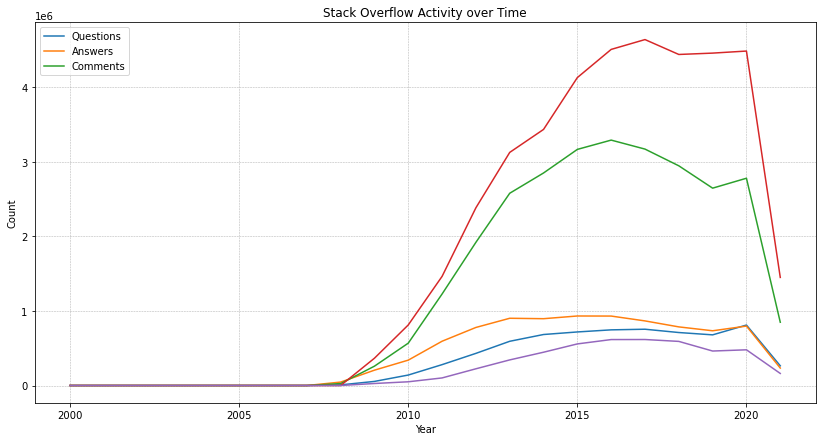

In [39]:
# Plot the SO activity over time
SO_activity_over_time = SO_activity.groupby('year')[['questioncount', 'answercount', 'commentcount', 'upvotecount', 'downvotecount']].sum()
yearly_trends.plot(kind='line', figsize=(14, 7))
plt.title('Stack Overflow Activity over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(['Questions', 'Answers', 'Comments'])
plt.show()

We can see that there is no data before 2007 and that there is a big dropoff in 2021, which indicates that the data was collected during that year and therefore doesn't include all of the data for 2021.

In [40]:
# Drop all the values that are not in the timeframe of 2007-2021
merged_df = merged_df[(merged_df.year>2006) & (merged_df.year<2021)]

In [41]:
# Save the final dataframe to an Excel file
merged_df.to_excel("FINAL.xlsx", index=False)

In [42]:
# Read the final datset
final_df = pd.read_excel(r"Final.xlsx")

This is a list of the columns in our final dataset and the corresponding description:

| Column                      | Description                                               |
|-----------------------------|-----------------------------------------------------------|
| **nuts3_code**              | NUTS 3 region code                                        |
| **year**             | Time period for the data                                  |
| **EMP (THS)**               | Employment in thousands for the region                    |
| **GDP (EUR_HAB)**           | GDP per inhabitant in euros                               |
| **GDP (EUR_HAB_EU27_2020)** | GDP per inhabitant in euros (indexed to EU27_2020)        |
| **GDP (MIO_EUR)**           | GDP in million euros                                      |
| **GDP (MIO_NAC)**           | GDP in million units of national currency                 |
| **GDP (MIO_PPS_EU27_2020)** | GDP in million Purchasing Power Standards (EU27_2020)     |
| **GDP (PPS_EU27_2020_HAB)** | GDP per inhabitant in PPS (EU27_2020)                     |
| **GDP (PPS_HAB_EU27_2020)** | GDP per inhabitant in PPS (indexed to EU27_2020)          |
| **GVA (MIO_EUR)**           | Gross Value Added in million euros                        |
| **GVA (MIO_NAC)**           | Gross Value Added in million units of national currency   |
| **POP (THS)**               | Population in thousands                                   |
| **nuts3_name**              | Name of the NUTS 3 region                                 |
| **country**                 | Country the NUTS 3 region belongs to                      |
| **questioncount**           | Number of questions posted from the region on StackOverflow|
| **answercount**             | Number of answers provided from the region on StackOverflow|
| **upvotecount**             | Number of upvotes received for the region on StackOverflow |
| **downvotecount**           | Number of downvotes received for the region on StackOverflow|
| **commentcount**            | Number of comments made from the region on StackOverflow  |


In [43]:
final_df

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,2007,Aargau,CH,0,0,0,0,0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,Aargau,CH,86,167,0,0,32,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009,Aargau,CH,370,2291,4158,265,3282,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,NaN,NaN,NaN,31791.60,39186.33,20892.36,NaN,NaN,30948.00,38146.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5385,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.0,41000.0,145.0,18408.07,174304.19,13722.47,30600.0,108.0,16305.80,154398.0,449.00
5386,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.0,41300.0,141.0,18787.46,181019.09,14044.57,30900.0,105.0,16657.12,160493.0,454.99
5387,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.0,41000.0,135.0,18855.66,193427.07,14793.54,32200.0,106.0,16710.18,171418.0,460.01
5388,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.0,40600.0,130.0,18820.58,199292.98,15097.04,32500.0,104.0,16714.73,176994.0,464.00


## Handling Missing Data

In [51]:
# Total number of rows
total_rows = len(final_df)
print(f"Total number of rows: {total_rows}")

Total number of rows: 5390


In [188]:
import warnings
warnings.filterwarnings('ignore')

# List of the indicators
indicators = [
    'EMP (THS)',
    'GDP (EUR_HAB)',
    'GDP (EUR_HAB_EU27_2020)',
    'GDP (MIO_EUR)',
    'GDP (MIO_NAC)',
    'GDP (MIO_PPS_EU27_2020)',
    'GDP (PPS_EU27_2020_HAB)',
    'GDP (PPS_HAB_EU27_2020)',
    'GVA (MIO_EUR)',
    'GVA (MIO_NAC)',
    'POP (THS)',
    'questioncount',
    'answercount',
    'upvotecount',
    'downvotecount',
    'commentcount'
]

# Create a DataFrame to hold the count data
data_counts_df = pd.DataFrame(columns=['Indicator', 'NaN Count', 'Zero Count', 'Data Count', 'Total'])

# Populate the DataFrame with counts for each indicator
for indicator in indicators:
    nan_count = final_df[indicator].isna().sum()
    zero_count = (final_df[indicator] == 0).sum()
    data_count = final_df[indicator].notna().sum() - zero_count
    total = nan_count + zero_count + data_count
    data_counts_df = data_counts_df.append({
        'Indicator': indicator,
        'NaN Count': nan_count,
        'Zero Count': zero_count,
        'Data Count': data_count,
        'Total': total
    }, ignore_index=True)

# Calculate the grand totals for each column
grand_totals = {
    'Indicator': 'Total',
    'NaN Count': data_counts_df['NaN Count'].sum(),
    'Zero Count': data_counts_df['Zero Count'].sum(),
    'Data Count': data_counts_df['Data Count'].sum(),
    'Total': data_counts_df['Total'].sum()
}
# Append the grand totals to the DataFrame
data_counts_df = data_counts_df.append(grand_totals, ignore_index=True)

# Display the DataFrame
data_counts_df

,Indicator,NaN Count,Zero Count,Data Count,Total
0,EMP (THS),1498,0,3892,5390
1,GDP (EUR_HAB),234,0,5156,5390
2,GDP (EUR_HAB_EU27_2020),234,0,5156,5390
3,GDP (MIO_EUR),156,0,5234,5390
4,GDP (MIO_NAC),156,0,5234,5390
5,GDP (MIO_PPS_EU27_2020),156,0,5234,5390
6,GDP (PPS_EU27_2020_HAB),234,0,5156,5390
7,GDP (PPS_HAB_EU27_2020),234,0,5156,5390
8,GVA (MIO_EUR),156,0,5234,5390
9,GVA (MIO_NAC),156,0,5234,5390


In order to find out for which countries there are missing values we plot the yearly trends of the indicators for each country:

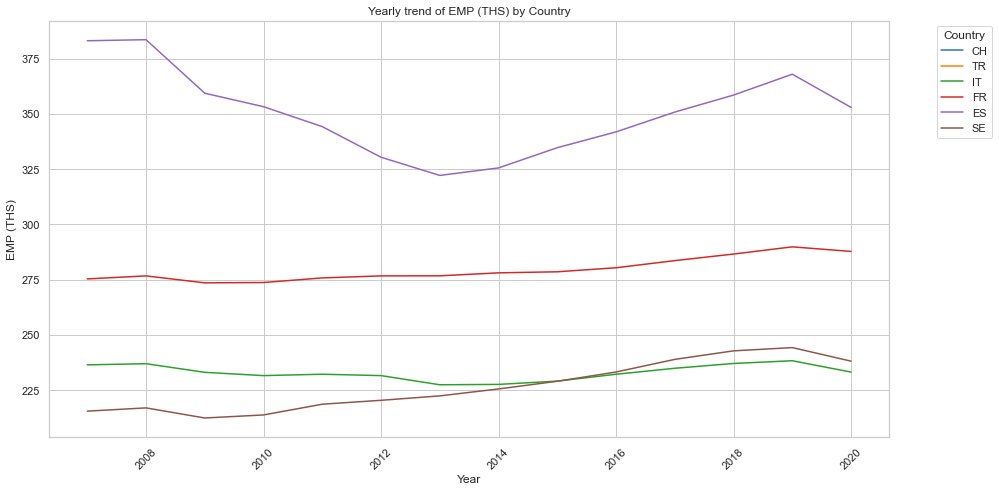

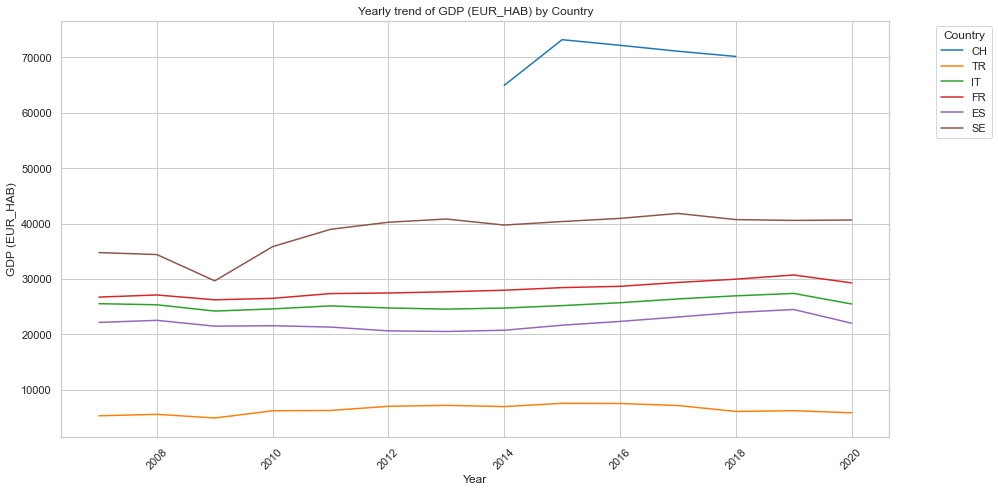

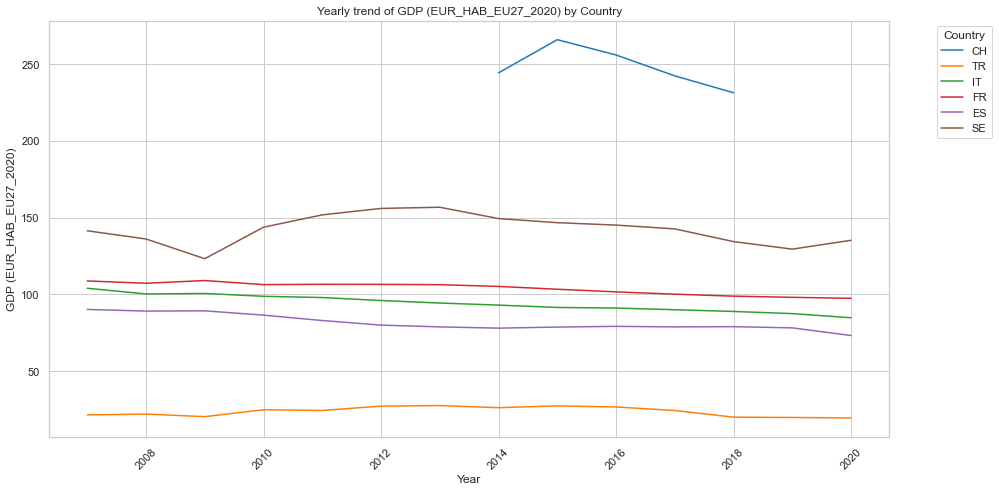

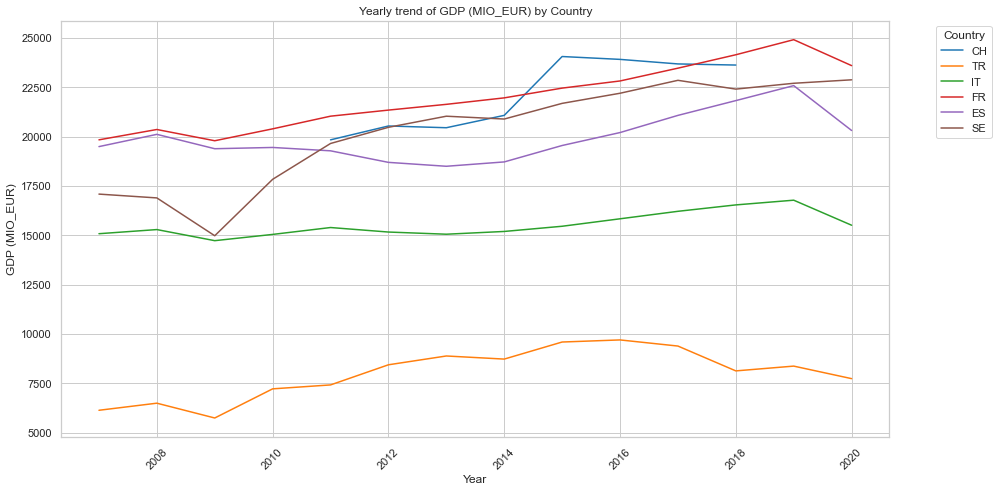

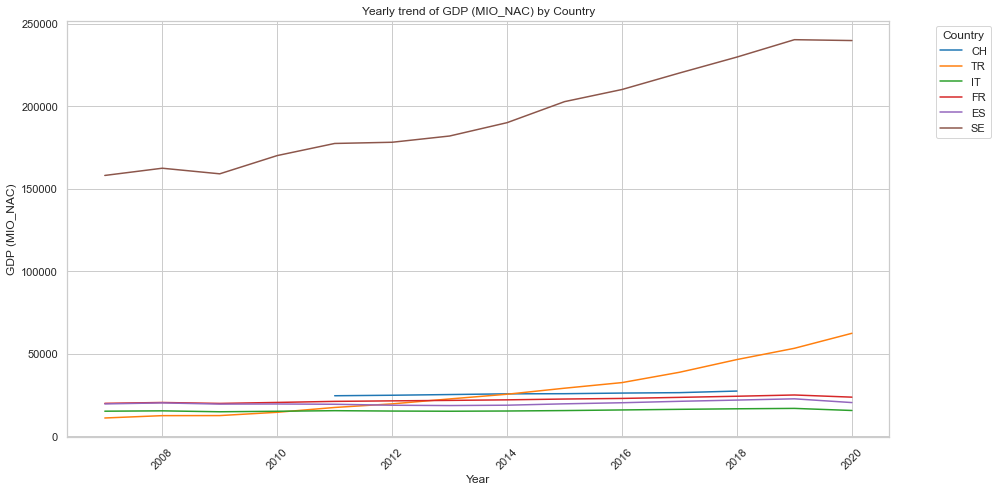

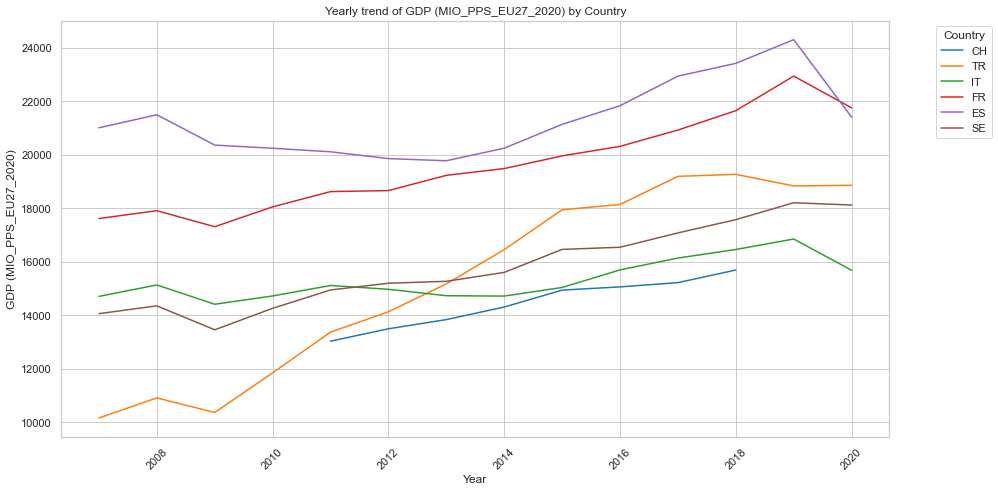

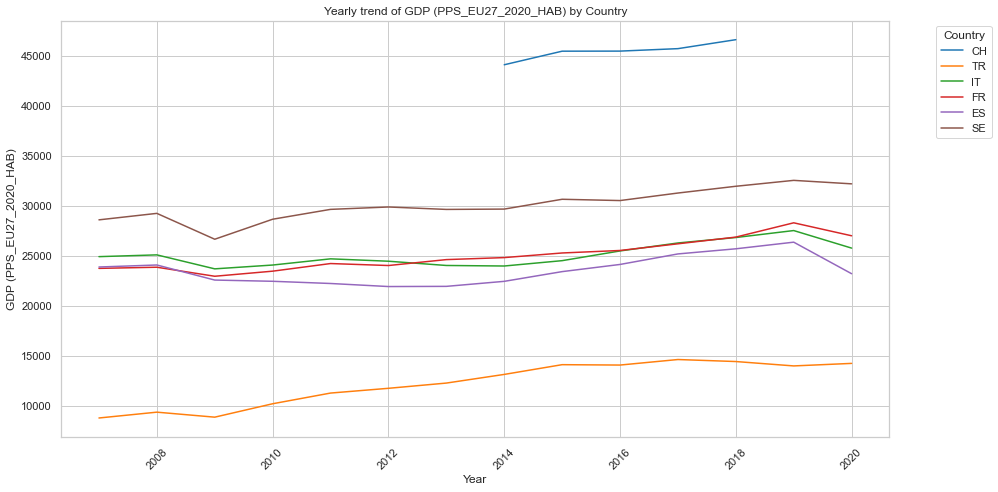

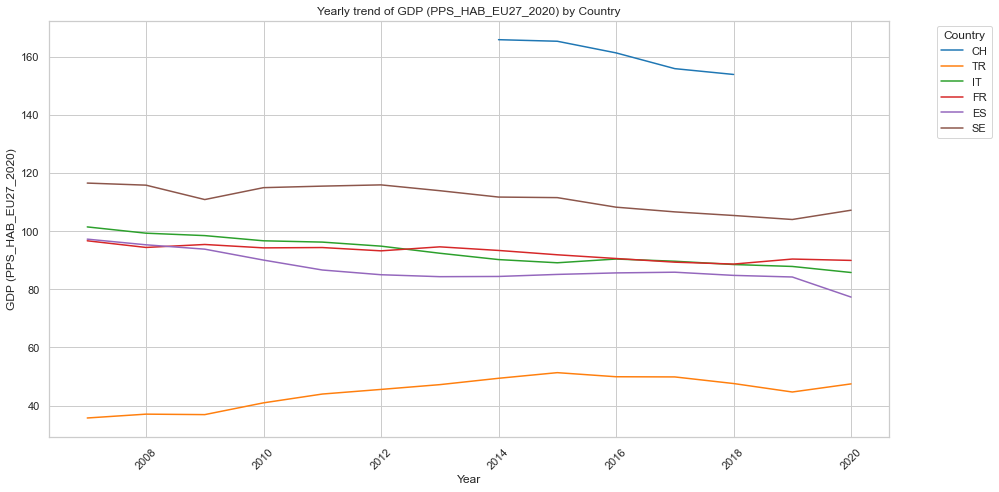

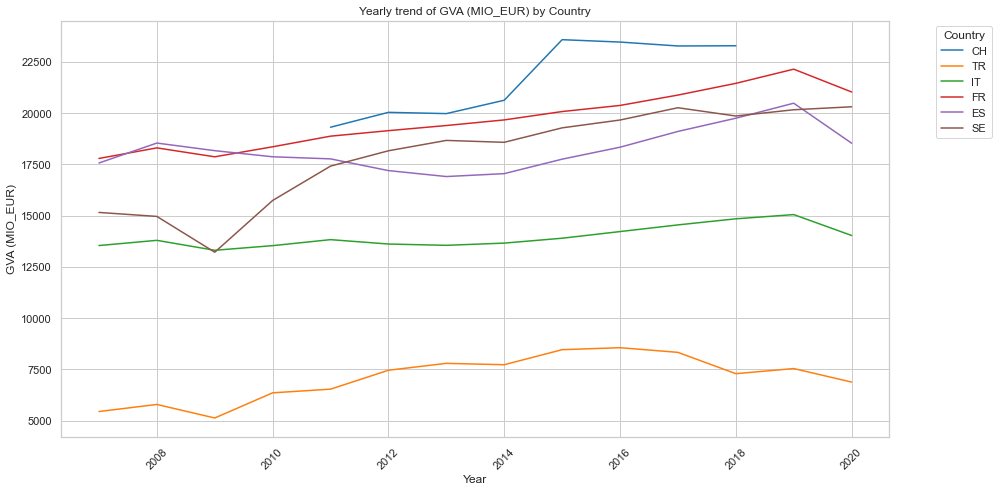

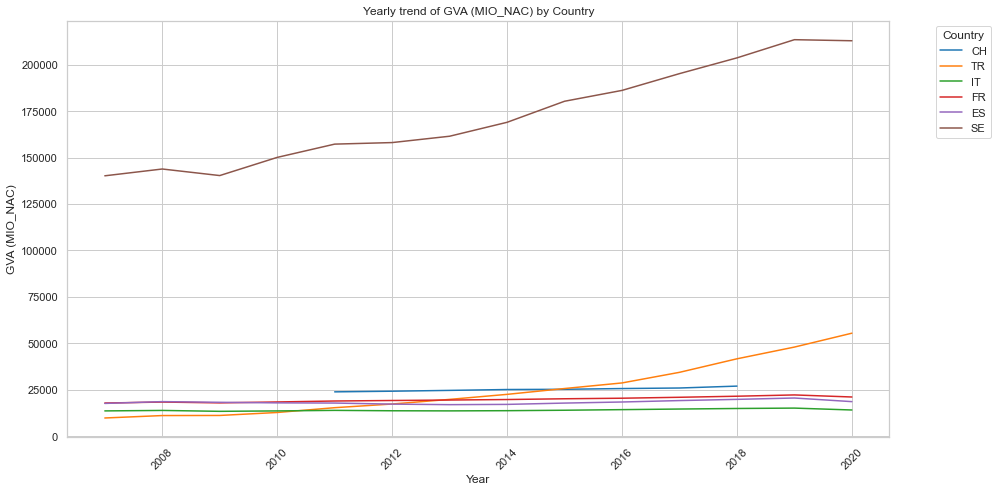

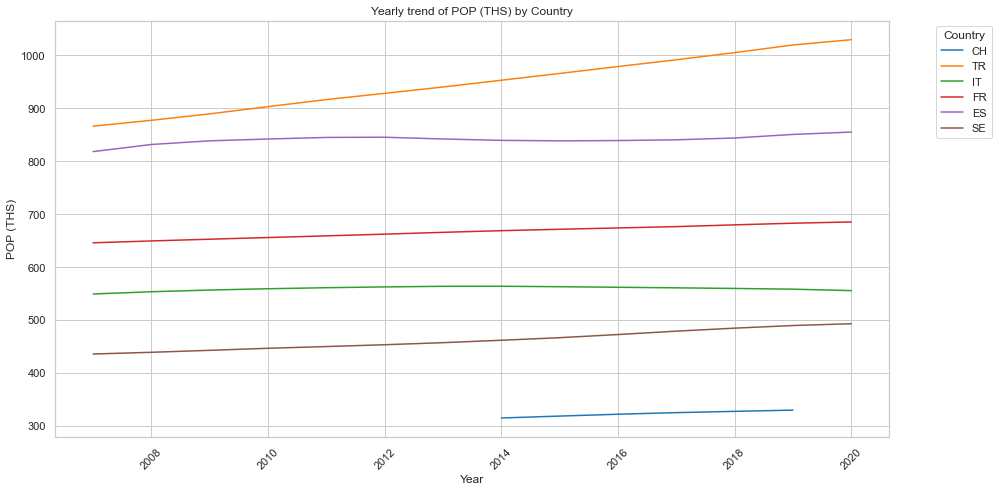

In [46]:
# Set the style
sns.set(style="whitegrid")

# Now, plot a line for each country
indicators = [
    'EMP (THS)',
    'GDP (EUR_HAB)',
    'GDP (EUR_HAB_EU27_2020)',
    'GDP (MIO_EUR)',
    'GDP (MIO_NAC)',
    'GDP (MIO_PPS_EU27_2020)',
    'GDP (PPS_EU27_2020_HAB)',
    'GDP (PPS_HAB_EU27_2020)',
    'GVA (MIO_EUR)',
    'GVA (MIO_NAC)',
    'POP (THS)'
]

# For each indicator, plot a line graph
for indicator in indicators:
    plt.figure(figsize=(14, 7))
    sns.lineplot(
        x='year',
        y=indicator,
        hue='country',
        data=final_df,
        palette='tab10',
        ci=None  # Remove the confidence interval for clarity
    )
    plt.title(f'Yearly trend of {indicator} by Country')
    plt.ylabel(indicator)
    plt.xlabel('Year')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend out of the plot
    plt.tight_layout()
    plt.show()

We can observe: 

- We don't have any data on employment for Switzerland and Turkey. 
- The data on GDP, GVA and population is complete for all countries except Switzerland.

We will handle this missing data by finding other data sources for certain countries or filling missing values in a meaningful way. 

### Switzerland Population

The population obtained from the Eurostats data was not complete. We found the complete data for the population by NUTS3 region on the website of the FSA of Switzerland.

Source: [Federal Statistics Office](https://www.bfs.admin.ch/bfs/en/home/statistics/catalogues-databases/data.assetdetail.26645086.html)

As the population data for the other countries (from Eurostats) is defined as the average annual population, we got the Switzerland population for each canton at the beggining and the end of each year and calculated the average value. These values were coherrent with the ones we had for Switzerland in the Eurostats data.

In the excel file we already mapped the canton to its Nuts3_code.

In [53]:
# Define the columns to read from each file
ch_pop_cols = ['nuts3_code', 'Year', 'POP']


# Read the files with only necessary columns
ch_pop_df = pd.read_csv("Data/Switzerland Population Data.csv", usecols=ch_pop_cols,encoding='unicode_escape')

In [104]:
ch_pop_df

,nuts3_code,Year,POP
0,CH040,2007,"1,295.81"
1,CH021,2007,960.94
2,CH061,2007,361.29
3,CH062,2007,34.97
4,CH063,2007,139.93
...,...,...,...
359,CH011,2020,809.93
360,CH012,2020,347.01
361,CH024,2020,176.2
362,CH013,2020,505.24


Now we update the population data for Switzerland in our final dataset.

In [55]:
# Merge the dataframes on 'nuts3_code' and 'year' with a left join
merged_df = pd.merge(final_df, ch_pop_df, left_on=['nuts3_code', 'year'], right_on=['nuts3_code', 'Year'], how='left')

# Ensure the 'POP (THS)' column is treated as strings
merged_df['POP (THS)'] = merged_df['POP (THS)'].astype(str)

# Replace commas and convert 'POP (THS)' to float
merged_df['POP (THS)'] = merged_df['POP (THS)'].str.replace(',', '').astype(float)

# Ensure 'POP' is also treated as strings and format it correctly before the assignment
merged_df['POP'] = merged_df['POP'].astype(str)
merged_df['POP'] = merged_df['POP'].str.replace(',', '').astype(float)

# Replace the 'POP (THS)' values only where there's a match (i.e., where 'POP' is not null)
merged_df.loc[merged_df['POP'].notnull(), 'POP (THS)'] = merged_df['POP']

# Drop the 'Year' and 'POP' columns as they are no longer needed
merged_df.drop(['Year', 'POP'], axis=1, inplace=True)

# Rename the merged_df back to final_df if you want to overwrite the original dataframe
final_df = merged_df

Check if there are still missing values for the population for Switzerland:

In [56]:
final_df[(final_df.country=='CH')]['POP (THS)'].isnull().sum()

0

In [187]:
# Save the new dataframe to an Excel file
final_df.to_excel("FINAL_updater.xlsx", index=False)

### Switzerland GDP

The GDP obtained from the Eurostats data was not complete. We found the complete data for the GDP by NUTS3 region on the website of the FSA of Switzerland.

Source: [Federal Statistics Office](https://www.bfs.admin.ch/bfs/en/home/statistics/national-economy/national-accounts/gross-domestic-product-canton.assetdetail.28405435.html)

Note: The data for the year 2007 is missing. The data only starts from the year 2008.

In [176]:
# Read the file
ch_gdp_df = pd.read_excel("Data/CH_gdp.xlsx",skiprows = 2)

# Drop unnecessary rows
ch_gdp_df = ch_gdp_df.drop([0])
ch_gdp_df = ch_gdp_df.truncate(after=26)

# Reset index
ch_gdp_df = ch_gdp_df.reset_index()
ch_gdp_df = ch_gdp_df.drop(columns = ['index','2021p'])

# Reshape the DataFrame
ch_gdp_df = pd.melt(ch_gdp_df, id_vars=['Canton'], var_name='year', value_name='GDP (MIO_CHF)')

In [177]:
ch_gdp_df

,Canton,year,GDP (MIO_CHF)
0,Zurich,2008,135763.68806
1,Berne,2008,73222.43163
2,Lucerne,2008,23065.83825
3,Uri,2008,1691.10825
4,Schwyz,2008,8323.13661
...,...,...,...
333,Vaud,2020,56442.69189
334,Valais,2020,19025.75615
335,Neuchâtel,2020,15320.30848
336,Geneva,2020,52015.88663


In [178]:
# Read the mapping file
ch_nuts_map = pd.read_excel("Data/CH_NUTS_map.xlsx")
ch_nuts_map.head()

,nuts3_region,nuts3_code
0,Aargau,CH033
1,Appenzell A. Rh.,CH053
2,Appenzell I. Rh.,CH054
3,Basel-Landschaft,CH032
4,Basel-Stadt,CH031


In [179]:
# Merge on the GDP data
merged_df = pd.merge(ch_gdp_df, ch_nuts_map, left_on=['Canton'], right_on=['nuts3_region'], how='left')
ch_gdp_df = merged_df

# Drop unnecessary columns
ch_gdp_df = ch_gdp_df.drop(columns = ['Canton','nuts3_region'])

ch_gdp_df

,year,GDP (MIO_CHF),nuts3_code
0,2008,135763.68806,CH040
1,2008,73222.43163,CH021
2,2008,23065.83825,CH061
3,2008,1691.10825,CH062
4,2008,8323.13661,CH063
...,...,...,...
333,2020,56442.69189,CH011
334,2020,19025.75615,CH012
335,2020,15320.30848,CH024
336,2020,52015.88663,CH013


When we want to merge the new GDP and GVA data of Switzerland on our main dataset, we have to keep the different currencies in mind.

### Switzerland GVA

The GVA obtained from the Eurostats data was not complete. We found the complete data for the GVA by NUTS3 region on the website of the FSA of Switzerland.

Source: [Federal Statistics Office](https://www.bfs.admin.ch/bfs/en/home/statistics/national-economy/national-accounts/gross-domestic-product-canton.assetdetail.28405434.html)

Note: The data for the year 2007 is missing. The data only starts from the year 2008.

In [180]:
# Read the file
ch_gva_df = pd.read_excel("Data/CH_gva_mapped.xlsx")

# Drop the region
ch_gva_df = ch_gva_df.drop(columns = ['nuts3_region'])

# Reshape the DataFrame
ch_gva_df = pd.melt(ch_gva_df, id_vars=['nuts3_code'], var_name='year', value_name='GVA (MIO_CHF)')

ch_gva_df

,nuts3_code,year,GVA (MIO_CHF)
0,CH033,2008,37981.40435
1,CH053,2008,2781.21994
2,CH054,2008,804.48386
3,CH032,2008,17950.68857
4,CH031,2008,29217.83197
...,...,...,...
333,CH062,2020,1958.58102
334,CH012,2020,18596.20347
335,CH011,2020,55082.44085
336,CH066,2020,19551.75653


***GDP and GVA Currency Correction***

The unit for the GDP and GVA data for Switzerland is "Million CHF", whereas the unit for the other countries is "Million EUR". We have to change the Switzerland data to EUR. 

In order to do this, we took the average CHF/EUR exchange rate per year provided by the [ECB Data Portal](https://data.ecb.europa.eu/data/datasets/EXR/EXR.M.CHF.EUR.SP00.A?chart_props=W3sibm9kZUlkIjoiMzIyNjk3IiwicHJvcGVydGllcyI6W3siY29sb3JIZXgiOiIiLCJjb2xvclR5cGUiOiIiLCJjaGFydFR5cGUiOiJsaW5lY2hhcnQiLCJsaW5lU3R5bGUiOiJTb2xpZCIsImxpbmVXaWR0aCI6IjEuNSIsImF4aXNQb3NpdGlvbiI6ImxlZnQiLCJvYnNlcnZhdGlvblZhbHVlIjpmYWxzZSwiZGF0ZXMiOlsiMjAwNy0wMS0wMVQwMDowMDowMC4wMDBaIiwiMjAyMC0xMi0zMVQwMDowMDowMC4wMDBaIl0sImlzVGRhdGEiOnRydWUsIm1vZGlmaWVkVW5pdFR5cGUiOiJub25lIiwieWVhciI6ImRhdGV3aXNlIiwic3RhcnREYXRlIjoiMjAwNy0wMS0wMSIsImVuZERhdGUiOiIyMDIwLTEyLTMxIiwic2V0RGF0ZSI6dHJ1ZSwic2hvd1RhYmxlRGF0YSI6ZmFsc2UsImNoYW5nZU1vZGUiOmZhbHNlLCJzaG93TWVudVN0eWxlQ2hhcnQiOmZhbHNlLCJkaXNwbGF5TW9iaWxlQ2hhcnQiOnRydWUsInNjcmVlblNpemUiOiJtYXgiLCJzY3JlZW5XaWR0aCI6MTQ0MCwic2hvd1RkYXRhIjpmYWxzZSwidHJhbnNmb3JtZWRGcmVxdWVuY3kiOiJ5ZWFybHkiLCJ0cmFuc2Zvcm1lZFVuaXQiOiJub25lIiwiZnJlcXVlbmN5IjoieWVhcmx5IiwidW5pdCI6Im5vbmUiLCJtb2RpZmllZCI6InRydWUiLCJzZXJpZXNLZXkiOiJtb250aGx5Iiwic2hvd3RhYmxlU3RhdGVCZWZvcmVNYXhTY3JlZW4iOmZhbHNlLCJpc2RhdGFjb21wYXJpc29uIjpmYWxzZSwic2VyaWVzRnJlcXVlbmN5IjoieWVhcmx5IiwiaW50aWFsU2VyaWVzRnJlcXVlbmN5IjoibW9udGhseSIsIm1ldGFkYXRhRGVjaW1hbCI6IjQiLCJpc1RhYmxlU29ydGVkIjpmYWxzZSwiaXNZZWFybHlUZGF0YSI6dHJ1ZSwicmVzcG9uc2VEYXRhRW5kRGF0ZSI6IjIwMjMtMTAtMzEiLCJpc2luaXRpYWxDaGFydERhdGEiOnRydWUsImlzRGF0ZXNGcm9tRGF0ZVBpY2tlciI6dHJ1ZSwiZGF0ZVBpY2tlckVuZERhdGUiOiIyMDIwLTEyLTMxIiwiaXNEYXRlUGlja2VyRW5kRGF0ZSI6dHJ1ZSwic2VyaWVza2V5U2V0IjoiRVhSLk0uQ0hGLkVVUi5TUDAwLkF8MTh8bm9uZXx5ZWFybHl8bm9uZXxBbm51YWwiLCJkYXRhc2V0SWQiOiIxOCIsImlzQ2FsbGJhY2siOmZhbHNlLCJpc1NsaWRlclRkYXRhIjpmYWxzZSwiaXNTbGlkZXJEYXRhIjp0cnVlLCJpc0luaXRpYWxDaGFydERhdGFGcm9tR3JhcGgiOnRydWUsImNoYXJ0U2VyaWVzS2V5IjoiRVhSLk0uQ0hGLkVVUi5TUDAwLkEiLCJ0eXBlT2YiOiJkb3duTG9hZCJ9XX1d) and calculated the value in EUR.

In [181]:
# Read the file
ch_eur = pd.read_csv("Data/CH_EUR.csv")

# Drop unnecessary columns
ch_eur = ch_eur.drop(columns = ['DATE'])

# Rename columns
ch_eur = ch_eur.rename(columns = {'TIME PERIOD':'year', 'Swiss franc/Euro (EXR.M.CHF.EUR.SP00.A) - Modified value (Annual)': 'exchange_ratio'})

# Drop years that are outside our time period
ch_eur = ch_eur[(ch_eur.year >2006) & (ch_eur.year <2021)]

ch_eur.head()

,year,exchange_ratio
8,2007,1.6427
9,2008,1.5871
10,2009,1.5099
11,2010,1.3823
12,2011,1.2340


**GDP Correction:**

In [182]:
# Merge the exchange ratio on the GDP data
merged_df = pd.merge(ch_gdp_df, ch_eur, on = 'year', how = 'left')

# Update the values for the GDP data
merged_df['GDP (MIO_EUR)'] = merged_df['GDP (MIO_CHF)'] / merged_df['exchange_ratio']

# Drop unnecessary columns 
merged_df = merged_df.drop(columns = ['GDP (MIO_CHF)', 'exchange_ratio'])

# Overwrite the old GDP dataset
ch_gdp_df = merged_df

In [183]:
ch_gdp_df.head()

,year,nuts3_code,GDP (MIO_EUR)
0,2008,CH040,85541.98731
1,2008,CH021,46135.991198
2,2008,CH061,14533.32383
3,2008,CH062,1065.53352
4,2008,CH063,5244.242083


**GVA Correction:**

In [185]:
# Merge the exchange ratio on the GVA data
merged_df = pd.merge(ch_gva_df, ch_eur, on = 'year', how = 'left')

# Update the values for the GVA data
merged_df['GVA (MIO_EUR)'] = merged_df['GVA (MIO_CHF)'] / merged_df['exchange_ratio']

# Drop unnecessary columns 
merged_df = merged_df.drop(columns = ['GVA (MIO_CHF)', 'exchange_ratio'])

# Overwrite the old GVA dataset
ch_gva_df = merged_df

In [189]:
ch_gva_df.head()

,nuts3_code,year,GVA (MIO_EUR)
0,CH033,2008,23931.324019
1,CH053,2008,1752.391116
2,CH054,2008,506.889207
3,CH032,2008,11310.370216
4,CH031,2008,18409.572157


### Switzerland Employment

The employment obtained from the Eurostats data was not complete. We found data for the employment by NUTS3 region on the website of the FSA of Switzerland.

Source: [Federal Statistics Office](https://www.bfs.admin.ch/bfs/en/home/statistics/catalogues-databases/tables.assetdetail.23985083.html)

In the Eurostats data, the employment indicator is defined as thousands persons per region. We didn't manage to find data with this exact metric for Switzerland. The indicator here is the economic activity rate by canton (economically active population / reference population x 100). Also, it is based on the population aged 15 and above.

We still think that this indicator is as meaningful as the one provided by Eurostats and we will therefore include it in our dataset.

Note: The data for the years 2007-2009 is missing. The data only starts from the year 2010.